In [2]:
#libreria para manejo de NDARRAY
import numpy as np;
import scipy as sp
#libreria para graficar
import matplotlib.pyplot as plt
#Lector de archivos csv
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg
from scipy.signal import welch as pwelch

In [3]:
ruta_carpeta = '../control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(data)

ruta_carpeta = '../parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(data)
print("Todo cargado")

Todo cargado


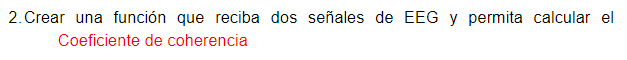

In [104]:
def coherence(data1,data2):
    X = np.fft.fft(data1)
    Y = np.fft.fft(data2)
    sxy = X * Y.conjugate()
    sxx = X * X.conjugate()
    syy = Y * Y.conjugate()
    return np.abs(np.mean(sxy.real))/np.sqrt(np.mean(sxx.real)*np.mean(syy.real))
#Nótese que en la ecuación cuando hablamos de la misma señal el n se torna como el numero de puntos así que se puede traducir en el promedio

In [107]:
coherence(datos_matriz[0][0][0],datos_matriz[0][0][0])

1.0

In [108]:
coherence(datos_matriz[0][1][0],datos_matriz[0][0][0])

0.7224334844699055

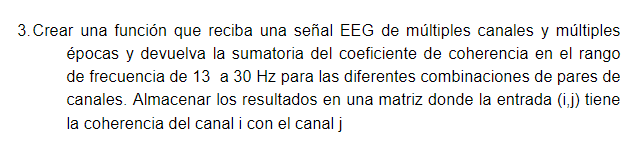

In [5]:
def deflrange(x,ini=13,end=30,fs=1000):
    N=len(x)
    f=np.linspace(0,fs,num=N)
    bf=np.where((f>=ini) &(f<=end))
    f=f[bf]
    x=x[bf]
    return f,x

In [109]:
def coherence_matrix(data, fs):
    n_channels, n_samples ,n_epochs,  = data.shape
    
    # Definir los límites de frecuencia para calcular la coherencia
    fmin = 13
    fmax = 30
    
    # Calcular el índice de las frecuencias correspondientes
    freqs = np.fft.fftfreq(n_samples, 1/fs)
    idx_band = np.where((freqs >= fmin) & (freqs <= fmax))[0]
    
    # Inicializar la matriz de coherencia
    coh_matrix = np.zeros((n_channels, n_channels))
    
    # Calcular la coherencia para cada par de canales
    for i in range(n_channels):
        for j in range(n_channels):
            #Se inician vectores en 0 para cada par de operaciones ya que al ser el calculo en épocas y lo que nos interesa es una 
            #sumatoria de las frecuencias es más rápido por este medio
            sum_sxy= np.zeros(len(idx_band))
            sum_sxx= np.zeros(len(idx_band))
            sum_syy= np.zeros(len(idx_band))
            for k in range(n_epochs):
                #Se toman los puntos por cada época
                x = data[i, : , k]
                y = data[j, :, k]
                #Se saca la transformada en la epoca
                X = np.fft.fft(x)
                Y = np.fft.fft(y)
                #Se generan los vectores con el rango en especifico
                sxy = X[idx_band] * Y[idx_band].conjugate()
                sxx = X[idx_band] * X[idx_band].conjugate()
                syy = Y[idx_band] * Y[idx_band].conjugate()
                #Se suman los vectores a los anteriores para cumplir con la sumatoria a lo largo de las épocas 
                sum_sxy+=sxy.real
                sum_sxx+=sxx.real
                sum_syy+=syy.real
            #Con los vectores de sumatoria en la época se aplican las operaciones de la ecuación
            coh_sum=np.abs(sum_sxy/n_epochs)/np.sqrt(sum_sxx*sum_syy/(n_epochs**2))
            #Finalmente se suman los puntos de los vectores 
            coh_matrix[i, j] = np.sum(coh_sum) 
            
    return coh_matrix

In [101]:
a=coherence_matrix(datos_matriz[0],1000)

In [102]:
df=pd.DataFrame(a) 
df

,0,1,2,3,4,5,6,7
0,35.000000,27.158471,9.494119,6.862532,15.858306,2.677902,7.541589,11.835994
1,27.158471,35.000000,25.844251,7.023974,7.602380,8.530986,12.622465,14.833776
2,9.494119,25.844251,35.000000,22.915743,6.583487,13.226007,14.876855,14.194794
3,6.862532,7.023974,22.915743,35.000000,27.385674,14.519833,13.343328,9.591165
4,15.858306,7.602380,6.583487,27.385674,35.000000,12.373601,9.186112,4.268638
5,2.677902,8.530986,13.226007,14.519833,12.373601,35.000000,32.126576,19.497182
6,7.541589,12.622465,14.876855,13.343328,9.186112,32.126576,35.000000,27.554583
7,11.835994,14.833776,14.194794,9.591165,4.268638,19.497182,27.554583,35.000000


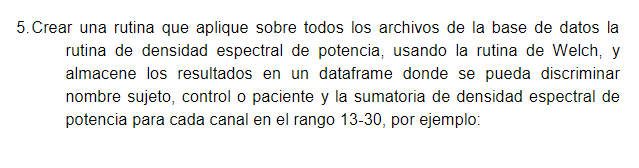

In [1]:
def PSD(data):
    fs=1000
    nperseg=2000
    noverlap=nperseg//2
    f,Pxx=pwelch(data,fs,"hamming",nperseg=nperseg,noverlap=noverlap)
    f,x=deflrange(Pxx,f)
    return np.sum(x)


In [6]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos anidados para recorrer la matriz de pacientes y los canales de cada uno de estos"""

for i in r:
    promcanales=["Control"]
    x=datos_matriz[i]
    senal_continua = np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]),order='F')
    for canales in senal_continua:
        canal=PSD(canales)
        promcanales.append(canal)
    datosprompaciente.append(promcanales)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales=["Parkinson"]
    x=datos_parkinson[i]
    senal_continua = np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]),order='F')
    for canales in senal_continua:
        canal=PSD(canales)
        promcanales.append(canal)
    datosprompaciente_p.append(promcanales)

In [7]:
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2'] #Los nombres de las columnas

In [8]:
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
Sujeto,,,,,,,,,
1,Control,13.776619,14.120766,15.728276,12.591008,23.230265,17.489788,16.621644,17.041586
2,Control,12.441170,14.145978,16.599989,15.256848,12.699892,82.185553,58.254511,66.513214
3,Control,10.146990,15.350419,24.017333,11.940686,24.039522,11.916369,13.094808,15.532258
4,Control,25.751189,27.903492,31.607562,28.234729,26.074602,92.564099,94.341480,98.628726
5,Control,12.196138,13.254994,14.361267,15.121136,16.428285,42.274466,29.493652,34.091202
6,Control,8.542977,10.134408,11.774719,8.420542,9.683191,20.841527,17.014321,16.934827
7,Control,7.531891,7.447244,8.539360,7.179014,6.571783,17.284218,12.177441,22.132771
8,Control,23.821712,23.058731,13.972009,14.041641,20.571574,77.644667,46.443246,62.238504
9,Control,7.788099,7.914130,10.142082,9.423261,8.922839,39.959937,39.440008,43.637009


In [9]:
df.to_csv("Tabla.cvs",index=False)

In [156]:
df=pd.read_csv("Tabla.cvs")

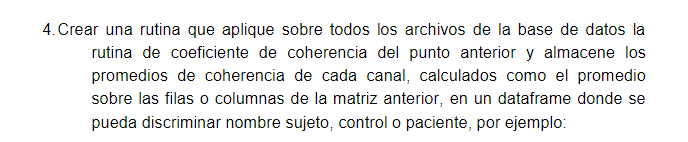

In [110]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos anidados para recorrer la matriz de pacientes y los canales de cada uno de estos"""

for i in r:
    promcanales="Control"
    x=coherence_matrix(datos_matriz[i],1000)
    x=x.mean(0).tolist()
    x.insert(0,promcanales)
    datosprompaciente.append(x)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales="Parkinson"
    x=coherence_matrix(datos_matriz[i],1000)
    x=x.mean(0).tolist()
    x.insert(0,promcanales)
    datosprompaciente_p.append(x)

In [111]:
names = ["Estado",'Coherencia_promedio_PSD_C3', 'Coherencia_promedio_PSD_C1', 'Coherencia_promedio_PSD_CZ', 'Coherencia_promedio_PSD_C2', 'Coherencia_promedio_PSD_C4', 'Coherencia_promedio_PSD_O1', 'Coherencia_promedio_PSD_OZ', 'Coherencia_promedio_PSD_O2'] #Los nombres de las columnas

In [112]:
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,Coherencia_promedio_PSD_C3,Coherencia_promedio_PSD_C1,Coherencia_promedio_PSD_CZ,Coherencia_promedio_PSD_C2,Coherencia_promedio_PSD_C4,Coherencia_promedio_PSD_O1,Coherencia_promedio_PSD_OZ,Coherencia_promedio_PSD_O2
Sujeto,,,,,,,,,
1,Control,14.553614,17.327038,17.766907,17.080281,14.782275,17.244011,19.031439,17.097017
2,Control,16.743210,21.139847,22.638254,21.293390,17.487544,21.888139,23.616915,22.059106
3,Control,21.153811,22.975754,22.349906,21.748414,22.318046,19.205083,21.304379,20.427635
4,Control,15.679078,19.772166,20.245217,19.296772,14.577410,19.785985,21.256705,19.999231
5,Control,16.143768,19.872700,21.147171,18.944445,15.212077,19.603350,21.416090,19.344375
6,Control,14.132686,16.506231,17.572053,17.065609,14.457549,16.924206,18.300402,17.407010
7,Control,14.530466,20.760944,22.146609,21.168574,15.481755,22.244769,19.189866,21.113584
8,Control,14.666671,17.151017,17.405649,17.474087,14.595465,16.454309,18.803429,16.924583
9,Control,16.541623,22.309434,23.311713,22.051210,17.844247,20.983615,22.630786,21.020140


In [113]:
df.to_csv("Tabla_coherencia.cvs",index=False)

# Estadística  

In [ ]:
df=pd.read_csv("Tabla.cvs") #Datos de PSD
df2=pd.read_csv("Tabla.cvs") #Datos de coherencia